# Assignment 5 <font size=3> Network Modeling, Statistics, and Machine Learning

Last updated: 2025 07 10

The objective of this assignment is to experiment with the concepts we covered in Module 5. In particular:

| Part | Pts | Recency |Title | Related lesson |
|------|-----|---------|-------|----------------------|
| 1 | 25 | | Structural properties of networks | 12. Network modeling |
| 2 | 40 | | Network generation | 12. Network modeling |
| 3 | 35 | | Network estimation | 13. Statistical analysis of network data |
| 4 | 15 | New | NLP using label propagation | 14. Machine learning in network science |
| 5 | 15 | New | NLP using a Graph Attention Network (GAT) | 14. Machine learning in network science |

### Note : Addition of Graph-Based ML bonus exercises

Due to popular demand, we have added graph-based ML exercises to this assignment from previous semesters (Parts 4 and 5)! 

As we test-drive these out, we are offering students flexability regarding which parts of the assignment they choose to complete. You may notice that there are more than 100 points available for this assignment. The first three Parts alone make up the previous iteration of A5 (from recent semesters) and are worth a combined 100 points. So you could complete Parts 1-3 alone and theoretically score a 100% on the assignment.

However, if you want to hedge your bets, you are welcome to complete the new parts 4 and 5 in order to buffer your score.

Note that 100 points is the *maximum* number that you may earn on this assignment. Extra points earned beyond that will not apply to any other assignment.

### Note : Part connections

* Part 2 calls some of the functions from Part 1.
* Parts 4 and 5 are *conceptually* linked. Either one *can* be done without doing the other, but there is a pedagogical throughline started in Part 4 that carries into Part 5.

# Imports

In [1]:
# Previous 7280 modules
import copy
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import ridgeplot                         # New since A1-A4
import scipy as sp
import seaborn as sns

# NLP data
import nlp_data                          # Custom module that holds NLP data (no need to install)

# Label propagation ML
import sklearn
from sklearn.semi_supervised import LabelPropagation
from sklearn.feature_extraction.text import TfidfVectorizer

# GAT ML
import torch                                               # New since A1-A4
import torch.nn.functional as F                            # New since A1-A4
from torch_geometric.data import Data, DataLoader          # New since A1-A4
from torch_geometric.nn import GATConv, global_mean_pool   # New since A1-A4
from sklearn.model_selection import train_test_split

# Custom Utility Functions

Put any utitlity functions that you write in this section (before the markdown cell labeled **Part 1**).

# Part 1 <font size=3> [25 pts] Structural properties of a graph

In this part (and the next), we will use an [American college football network](https://figshare.com/articles/dataset/American_College_Football_Network_Files/93179?file=94935). The goal is to show the structural properties of the empirical network.

## 1.0 <font size=3> [0 pts] Setup

Run the cells below to load the network.

In [2]:
# Run, but do not modify the contents of this cell
def load_football_network() -> nx.Graph:    
    G = nx.read_gml("data/football.gml")
    return G    

**Unit test**

Running the cell below should produce the following output:

> `Graph with 115 nodes and 613 edges`

In [3]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
print(G_us_football)

Graph with 115 nodes and 613 edges


Run the cells below to load utility functions that you may use in later sub parts.

In [4]:
# Utility function
def util_community_labels(G, list_of_communities):
    G_nodes = list(G.nodes)
    
    node_community_dict = {}
    for idx in range(len(list_of_communities)):
        community = list_of_communities[idx]
        for node in community:
            node_community_dict[node] = idx

    labels = []
    
    for node in G_nodes:
        labels.append(node_community_dict[node])
    
    return labels

In [5]:
# Utility function
def util_ground_truth_community_labels(G):
    return list((nx.get_node_attributes(G,"value")).values())

In [6]:
# Utility function
def util_plot_nmi_vs_resolution(resolutions:list, nmis:list) -> None:
    plt.plot(resolutions, nmis)
    plt.title("NMI vs Louvain Resolution in\nGround Truth vs Louvain communities")
    plt.xlabel("Louvain Resolution")
    plt.ylabel("NMI score")
    plt.show()

In [7]:
# Utility function
def util_plot_best_partition(G:nx.Graph, partition:list) -> None:
    
    # Initialize list of nodes of G
    G_nodes = list(G.nodes)

    # Get ground truth labels
    ground_truth_labels = util_ground_truth_community_labels(G)
    #indices_comb = list(ground_truth_labels) + [len(ground_truth_labels)]
    
    # Get community counts
    comm_ct_louvain = len(partition)
    comm_ct_truth = max(ground_truth_labels)
    comm_ct_max = max(comm_ct_louvain, comm_ct_truth)

    # Initialize set of possible community colors
    palette = sns.color_palette("hls", comm_ct_max)

    # Generate dict for louvain communities
    louvain_comm_dict = {}
    for i in range(len(partition)):
        community = partition[i]
        for node in community:
            louvain_comm_dict[node] = i

    # Generate louvain node color list
    node_colors_louvain = []
    for node in G_nodes:
        color_idx = louvain_comm_dict[node]
        node_colors_louvain.append(palette[color_idx])

    # Generate ground truth node color list
    node_colors_truth = []
    for comm_idx in util_ground_truth_community_labels(G):
        node_colors_truth.append(palette[comm_idx])

    plt.figure(figsize=(20,10))
    
    # Generate spring layout via a fixed seed
    pos=nx.spring_layout(G, seed=2, iterations=1000, threshold=1e-100)

    # Set title fontsize
    title_fontsize = 20
    
    # Set edge color
    edge_color = "#cccccc"
    
    # Create ground truth communities subplot
    plt.subplot(121)
    nx.draw_networkx(G, pos=pos, node_color=node_colors_truth, edge_color=edge_color, with_labels=False)
    plt.title("Ground truth\n"+str(comm_ct_truth)+" communities", fontsize=title_fontsize)

    # Create Louvain communities subplot
    plt.subplot(122)
    nx.draw_networkx(G, pos=pos, node_color=node_colors_louvain, edge_color=edge_color, with_labels=False)
    plt.title("Louvain\n"+str(comm_ct_louvain)+" communities", fontsize=title_fontsize)

    # Show final figure
    plt.show()

    return

In [8]:
# Utility function
def util_plot_p_matrix(p:np.ndarray):
    plt.imshow(p, cmap='viridis')
    plt.title("Intercommunity density matrix of\nBest Louvain community partition")
    plt.xlabel("Community ID")
    plt.ylabel("Community ID")
    plt.show()

## 1.1 <font size=3> [5 pts] Descriptive graph statistics

In the body of the function below:
1. Compute the following for the parameter graph `G`:
    * network diameter,
    * characteristic path length (CPL),
    * average clustering coefficient,
    * transitivity,
    * assortativity, and
    * degree sequence (a list of all the degrees for each node).
1. Return a dictionary of the results with the name of each statistic as the key.

In [9]:
def calculate_graph_statistics(G:nx.Graph) -> dict:
    """
    params
        G               NetworkX Graph
        
    return
        graph_stats     dict
        
    """
    graph_stats = {
        "assortativity": nx.degree_pearson_correlation_coefficient(G),
        "average_clustering": nx.average_clustering(G),
        "CPL": nx.average_shortest_path_length(G),
        "degree_sequence": [deg for i, deg in G.degree()],
        "diameter": nx.diameter(G),
        "transitivity": nx.transitivity(G),
    }

    return graph_stats

**Unit test**

Running the cell below should produce the following output:
> `-1.0`
>
> `0.0`
>
> `1.8`
>
> `[9, 1, 1, 1, 1, 1, 1, 1, 1, 1]`
>
> `2`
>
> `0`

In [10]:
# Run, but do not modify the contents of this cell
G_sc = nx.star_graph(9)
print(calculate_graph_statistics(G_sc)["assortativity"])
print(calculate_graph_statistics(G_sc)["average_clustering"])
print(calculate_graph_statistics(G_sc)["CPL"])
print(calculate_graph_statistics(G_sc)["degree_sequence"])
print(calculate_graph_statistics(G_sc)["diameter"])
print(calculate_graph_statistics(G_sc)["transitivity"])

-1.0
0.0
1.8
[9, 1, 1, 1, 1, 1, 1, 1, 1, 1]
2
0


## 1.2 <font size=3> [5 pts] Community assignments and NMI

In the body of the function below:
1. Compute the ground truth community labels of the graph. The ground truth label in the `"value"`
field associated with each node in the graph.
1. Compute an evenly spaced list of `res_ct` different resolution parameters (starting at `res_min` and ending at `res_max`).
1. For each resolution:
    * Compute the Louvain community labels
    * Using [`sklearn.metrics.normalized_mutual_info_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html), find the NMI between the Louvain and ground truth community labels.
    * Store the resolution and nmi in their respective lists
1. Return the resolution and nmi lists

In [11]:
import community as community_louvain
def sweep_louvain_resolutions(G:nx.Graph, res_min:int=1, res_max:int=11, res_ct:int=10) -> tuple:
    """
    params
        G                  nx.Graph
        res_min            int
        res_max            int
        res_ct             int
        
    return
        resolutions        list[float]
        nmis               list[float]
    
    """

    resolutions = np.linspace(res_min, res_max, res_ct)
    nmis = []
    gts = util_ground_truth_community_labels(G)

    for r in resolutions:
        par = community_louvain.best_partition(G, resolution=r)
        comms = {}
        for node, c in par.items():
            comms.setdefault(c, []).append(node)
        lv = util_community_labels(G, list(comms.values()))
        nmi = sklearn.metrics.normalized_mutual_info_score(gts, lv)
        nmis.append(nmi)

    return list(resolutions), nmis

**Unit test**

Running the cell below should produce the following output:

> `(between 0.85 to 0.90)`

Note that the stochasticity in the Louvain algorithm will carry through to the NMI values. The values listed are approximations.

In [12]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
sweep = sweep_louvain_resolutions(G=G_us_football, res_min=1, res_max=2, res_ct=2)
a = round(sweep[1][0],2)
print(a)

0.89


## 1.3 <font size=3> [5 pts] Optimize Louvain resolution based on NMI

In the body of the function below:
1. Return the resolution that provides the largest NMI, along with the list of community lists as provided by the NetworkX function [`community.louvain_communities`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html).

In [13]:
def calculate_best_partition(G:nx.Graph, resolutions:list, nmis:list) -> tuple:
    """
    params
        G                   nx.Graph
        resolutions         list[float]
        nims                list[float]

    return
        best_res            float
        partition           list[list[str]]
    
    """
    
    best_res = resolutions[nmis.index(max(nmis))]
    partition = nx.community.louvain_communities(G, resolution=best_res, seed=42)
    
    return best_res, partition

**Unit test**

Running the cell below should produce the following output:

> `best_res        :  1.0`
>
> `community count :  ~10`

In [14]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
resolutions, nmis = sweep_louvain_resolutions(G=G_us_football, res_min=1, res_max=1, res_ct=1)
best_res, partition = calculate_best_partition(G=G_us_football, resolutions=resolutions, nmis=nmis)
print("best_res        : ", best_res)
print("community count : ", len(partition))

best_res        :  1.0
community count :  10


## 1.4 <font size=3> [5 pts] Inter-community density

In the body of the function below:
1. Compute the intercommunity connection density matrix. This matrix $P$ was described in *L12: Generating Networks with Community Structure*.
2. Return the matrix $P$, as well as the sizes of the communities.

In [15]:
def calculate_inter_community_density(G:nx.Graph, partition:list) -> tuple:
    """
    params
        G                      nx.Graph
        partition              list[list[int]]
        
    return
        p                      np.array
        sizes                  list[int]
    
    """

    k = len(partition)  
    sizes = [len(comm) for comm in partition]
    p = np.zeros((k, k))  

    comm_sets = [set(comm) for comm in partition]

    for i in range(k):
        for j in range(k):
            nodes_i = comm_sets[i]
            nodes_j = comm_sets[j]
            if i == j:
                subgraph = G.subgraph(nodes_i)
                actual_edges = subgraph.number_of_edges()
                possible_edges = sizes[i] * (sizes[i] - 1) / 2
            else:
                actual_edges = 0
                for u in nodes_i:
                    for v in G[u]:
                        if v in nodes_j:
                            actual_edges += 1
                actual_edges /= 2  
                possible_edges = sizes[i] * sizes[j]
            
            if possible_edges > 0:
                p[i, j] = actual_edges / possible_edges
            else:
                p[i, j] = 0.0
    
    return p, sizes

**Unit test**

Running the cell below should produce the following output:

> `p.shape : (9,9) or (10,10)`

In [16]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
resolutions, nmis = sweep_louvain_resolutions(G=G_us_football, res_min=1, res_max=1, res_ct=1)
best_res, partition = calculate_best_partition(G=G_us_football, resolutions=resolutions, nmis=nmis)
p, sizes = calculate_inter_community_density(G=G_us_football, partition=partition)
print(f"p.shape : {p.shape}")

p.shape : (10, 10)


## 1.5 <font size=3> [0 pts] Visualization

Run the cells below to visualize:
1. NMI vs Louvain resolution. The NMI is calculated between the ground truth and Louvain communities at that resolution.
2. A side-by-side comparison of the ground truth communities with the Louvain communities at the best resolution.
3. A heatmap of the intercommunity density matrix for the best Louvain community partition.

In [17]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
resolutions, nmis = sweep_louvain_resolutions(G_us_football)
best_resolution, partition = calculate_best_partition(G_us_football, resolutions, nmis)
p, sizes = calculate_inter_community_density(G_us_football, partition)
pass

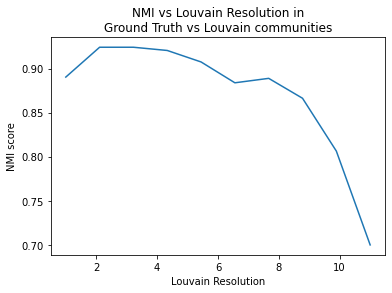

In [18]:
# Run, but do not modify the contents of this cell
util_plot_nmi_vs_resolution(resolutions, nmis)

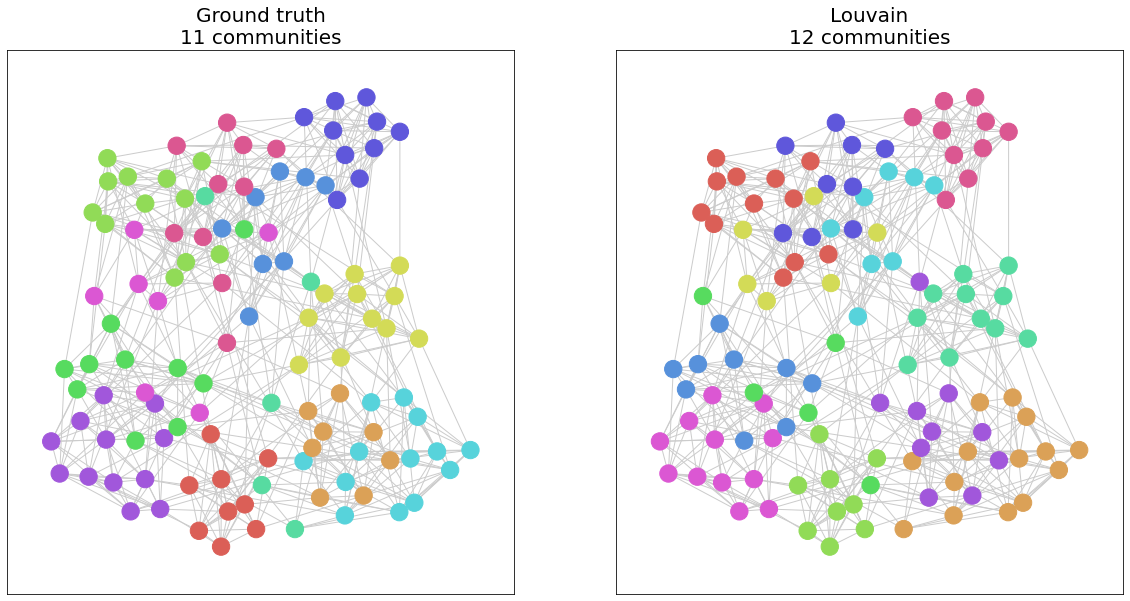

In [19]:
# Run, but do not modify the contents of this cell
util_plot_best_partition(G_us_football, partition)

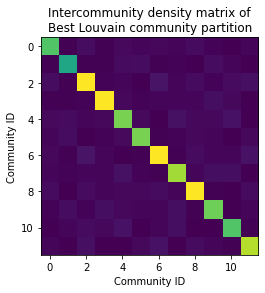

In [20]:
# Run, but do not modify the contents of this cell
util_plot_p_matrix(p)

## 1.6 <font size=3> [5 pts] Analysis

Use the visualizations above to choose responses below.

**Question 1.** How does the resolution impact the NMI?

In [21]:
def part_1_analysis_q1_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "increasing the resolution decreases the number of communities, which means the lowest resolution always gives the community partition that is most alike the ground truth communities"
    #return "increasing the resolution decreases the number of communities, which means the highest resolution always gives the community partition that is most alike the ground truth communities"
    #return "increasing the resolution decreases the number of communities, which means that in a given sweep, there will always be a resolution which gives a minimum NMI that is less than any other NMI found with any other resolution (even resolutions outside the sweep interval)"
    #return "increasing the resolution increases the number of communities, which means the lowest resolution always gives the community partition that is most alike the ground truth communities"
    #return "increasing the resolution increases the number of communities, which means the highest resolution always gives the community partition that is most alike the ground truth communities"
    return "increasing the resolution increases the number of communities, which means that if the parameter values of a Louvain NMI sweep are chosen properly, the NMI will generally increase to a global maximum and then decrease after that"
#     return "Yo"

**Question 2.** Is the partition for the best NMI a good match to the ground truth?

In [22]:
def part_1_analysis_q2_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "no, because the node colors in the ground truth diagram don't perfectly match the node colors in the Louvain diagram"
    #return "no, because the NMI is not very close to 0.0"
    #return "no, because given the stochasticity of the Louvain algorithm, there are sometimes more Louvain communities than ground truth communities"
    #return "yes, because the NMI is very close to 1.0"
    #return "yes, because given the stochasticity of the Louvain algorithm, there are sometimes exactly the same number of Louvain communities as ground truth communities"
    return "yes, because the NMI is higher than the NMI of the other partitions that were generated"
#     return "Yo"

# Part 2 <font size=3> [40 pts] Network generation

In this part, we  will work with the following network generation algorithms:
1. Configuration graph
2. Stochastic block matrix
3. Heirarchical random graph

These algorithms will make use of the statistics that were calculated in the prior part.

## 2.1 <font size=3> [8 pts] Generation algorithm : Configuration Graph

We provide a utility function below.

In [23]:
# Utility function
def util_get_LCC(G:nx.Graph):
    LCC = nx.Graph()
    components = list(nx.connected_components(G))
    largest_comp_size, largest_comp_node_set = 0, []
    for component in components:
        if len(component) > largest_comp_size:
            largest_comp_size = len(component)
            largest_comp_node_set = component
    for edge in list(G.edges):
        if edge[0] in largest_comp_node_set:
            LCC.add_edges_from([edge])
    return LCC

In the body of the function below:
1. Use NetworkX's [`configuration_model`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html) function to generate `n_graphs` number of configruation graphs based on a given degree sequence.
2. Return a list of the generated graphs.

In [24]:
def generate_configuration_graphs(degree_sequence:list, n_graphs:int=100) -> list:
    """
    params
        degree_sequence         list[int]
        n_graphs                int

    return
        graphs                  list[nx.Graph]
    
    """

    graphs = [util_get_LCC(nx.Graph(nx.configuration_model(degree_sequence))) for i in range(n_graphs)]
    return graphs

## 2.2 <font size=3> [8 pts] Generation algorithm : Stochastic Block Model

In the body of the function below:
1. Use NetworkX's [`stochastic_block_model`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.stochastic_block_model.html) function to generate `n_graphs` number of stochastic block model graphs based on a given inter-community density matrix $P$.
2. Return a list of the generated graphs.

In [25]:
def generate_sbm_graphs(p:np.ndarray, sizes:list, n_graphs:int=100) -> list:
    """
    params
        p          np.ndarray    element (i,j) is the density of edges between community_i and community_j
        sizes      list[int]
        n_graphs   int
    
    return
        graphs     list[nx.Graph]
        
    """
    graphs = [nx.stochastic_block_model(sizes, p.tolist(), seed=None) for i in range(n_graphs)]
    return graphs

## 2.3 <font size=3> [8 pts] Generation algorithm : Hierarchical Random Graph

Here you will be working with the Hierarchical Random Graphs. Using PyHRG, we have pre-composed a
dendrogram fitted on the empirical US football network. This dendogram is drawn from the file `data/football-hrg.gml`. It is formmatted as a directed graph, with edges having a parent node as a source and child node as a target. Note the following:
* Each **leaf** node (node with no outgoing edges) in the dendrogram represents a **node in the empirical network**,
* Each **non-leaf** node stores **probability** information about its left/right child (“L” / “R”). The L probability is the probability of any two distinct left leaf nodes (leaf nodes found as descendants along the left branch) having an edge between them. Analogously for R.

In [26]:
# Utility function
def util_get_root(G:nx.DiGraph):
    for node in list(G.nodes):
        if len(list(G.predecessors(node))) < 1:
            return node

In [27]:
# Utility function
def util_get_lowest_parent(G:nx.DiGraph, leaves=[]):
    if len(leaves) > 1:
        leafA, leafB = leaves[0], leaves[1]
        root = util_get_root(G)
        pathA, pathB = nx.shortest_path(G, source=root, target=leafA), nx.shortest_path(G, source=root, target=leafB)
        parent_dist, parent = 0, root
        for node in pathA:
            if node in pathB:
                dist = nx.shortest_path_length(G, source=root, target=node)
                if dist > parent_dist:
                    parent_dist, parent = dist, node
        return parent
    else:
        raise ValueError("Too few elements in the leaves parameter")

In the body of the function below:
1. For each leaf node $L_A$ (ie, node with no outgoing edges) in the argument dendrogram, construct a dictionary where the keys are all the leaf nodes and the value for each key $L_B$ is the probability found in the node of the dendrogram at the is the nearest common ancestor of $L_A$ and $L_B$.
2. Return the dictionary of dictionaries.

In [28]:
def calculate_edge_probability(dendrogram:nx.DiGraph) -> dict:
    """
    params
        dendrogram        nx.DiGraph

    return
        edge_probs        dict[str, dict[str, float]]    a dictionary of edge probabilities between all pairs of leaf nodes.
    
    """

    leaf_nodes = [n for n in dendrogram.nodes if dendrogram.out_degree(n) == 0]
    edge_probs = {}

    for LA in leaf_nodes:
        edge_probs[LA] = {}
        for LB in leaf_nodes:
            parent = util_get_lowest_parent(dendrogram, [LA, LB])
            p = dendrogram.nodes[parent].get('p', 0.0)
            edge_probs[LA][LB] = p

    return edge_probs

**Unit test**

Running the cell below should produce the following output:

> `probability between KansasState and California : 0.0476`

In [29]:
# Run, but do not modify the contents of this cell
G_us_football = load_football_network()
G_us_football_nodes = list(G_us_football.nodes)
dendrogram = nx.read_gml("data/football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
prob = edge_probs['KansasState']['California']
print(f"probability between KansasState and California : {prob:.4f}")

probability between KansasState and California : 0.0476


In the body of the function below:
1. Generate a random graph based on the edge probabilities. That is, for each pair of distinct nodes, generate an edge with probability p from `edge_probs` associated to that node pair.
2. Return the generated graph.

In [30]:
def generate_graph_from_prob(edge_probs:dict) -> nx.Graph:
    """
    params
        edge_probs        dict[str, dict[str, float]]    a dictionary of edge probabilities between all pairs of leaf nodes.

    return
        H                 nx.Graph
    
    """

    H = nx.Graph()
    nodes = list(edge_probs.keys())
    H.add_nodes_from(nodes)

    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            u, v = nodes[i], nodes[j]
            p = edge_probs[u][v]
            if random.random() < p:
                H.add_edge(u, v)

    return H

In the body of the function below:
1. Generate `n_graph` number of random graphs using the function `generate_graph_from_prob`.
2. Return a list of the generated graphs.

In [31]:
def generate_hrg_graphs(edge_probs:dict, n_graphs:int=100) -> list:
    """
    params
        edge_probs          dict[str, dict[str, float]]    a dictionary of edge probabilities between all pairs of leaf nodes.
        n_graphs            int

    return
        graphs              list[nx.Graph]
    
    """

    graphs = [generate_graph_from_prob(edge_probs) for i in range(n_graphs)]
    return graphs

## 2.4 <font size=3> [8 pts] Network statistics

We provide a utility function below.

In [32]:
# Utility function
def util_get_LCC(G:nx.Graph):
    LCC = nx.Graph()
    components = list(nx.connected_components(G))
    largest_comp_size, largest_comp_node_set = 0, []
    for component in components:
        if len(component) > largest_comp_size:
            largest_comp_size = len(component)
            largest_comp_node_set = component
    for edge in list(G.edges):
        if edge[0] in largest_comp_node_set:
            LCC.add_edges_from([edge])
    return LCC

In the body of the function below:
1. Complete the calculate_generated_statistic function to calculate the network diameter, CPL, average clustering coefficient, transitivity, and assortativity for each graph in a list of graphs.
2. Format the return as a dictionary where the key is a string describing the property and the value is a list of the result for each of the graphs in the list. Note if any of your graphs are not connected, you may use the `util_get_LCC` utility function to find the LCC of the graph and find the statistics for that graph.

In [33]:
def calculate_generated_statistics(graphs:list) -> dict:
    """
    params
        graphs                 list[nx.Graph]

    return
        graph_statistics       dict[str, list]
    
    """

    graph_statistics = {
        "diameter" : [],
        "CPL" : [],
        "average_clustering" : [],
        "transitivity" : [],
        "assortativity" : []
    }
    
    for G in graphs:
        Gc = G if nx.is_connected(G) else util_get_LCC(G)

        graph_statistics["diameter"].append(nx.diameter(Gc))
        graph_statistics["CPL"].append(nx.average_shortest_path_length(Gc))
        graph_statistics["average_clustering"].append(nx.average_clustering(Gc))
        graph_statistics["transitivity"].append(nx.transitivity(Gc))
        graph_statistics["assortativity"].append(nx.degree_assortativity_coefficient(Gc))

    return graph_statistics

## 2.5 <font size=3> [0 pts] Visualization

Run the cells below to see the following visualizations:
1. A set of three bar plot sets, one for each generation algorithm.
2. A set of five bar plot sets, one for each network statistic.

Use these visualizations to answer the analysis questions below.

In [34]:
def util_plot_graph_statistics(graph_statistics:list) -> None:

    stats = list(graph_statistics[1].keys())

    title_dict = {1 : "Configuration Model", 2 : "Stochastic Block Model", 3 : "Hierarchical Random Graph"}

    # Organized as generation method --> stat
    plt.figure(figsize=(20,4))
    for i in range(1,4):
        plt.subplot(151 + i)
        plt.boxplot(graph_statistics[i].values(), labels=graph_statistics[i].keys())
        for j in range(len(stats)):
            stat = stats[j]
            plt.plot(j+1, graph_statistics[0][stat], marker='*', markersize=10, label="Empirical value")
        plt.title(title_dict[i])
        plt.xticks(rotation=90)
    plt.legend()

    plt.show()
    
    # Organized as stat --> generation method
    stat_dict_emp, stat_dict_config, stat_dict_sbm, stat_dict_hrg = graph_statistics
    plt.figure(figsize=(20,5))
    for i in range(len(stats)):
        stat = stats[i]
        data_config, data_sbm, data_hrg = stat_dict_config[stat], stat_dict_sbm[stat], stat_dict_hrg[stat]
        data_dict = {'Config' : data_config, 'SBM' : data_sbm, 'HRG' : data_hrg}
        plt.subplot(150 + i + 1)
        plt.boxplot(data_dict.values(), labels=data_dict.keys())
        plt.plot(4.0, stat_dict_emp[stat], marker='*', markersize=20)

        # Add ground truth value onto plot
        
        plt.title(stat)

    plt.show()

In [35]:
# Run, but do not modify the contents of this cell
G = load_football_network()

graph_stats = calculate_graph_statistics(G)

# Configuration Model
config_graphs = generate_configuration_graphs(graph_stats['degree_sequence'])

# Stochastic Block Model
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
p, sizes = calculate_inter_community_density(G, partition)
sbm_graphs = generate_sbm_graphs(p, sizes)

# Hierarchical Random Graph Model
dendrogram = nx.read_gml("data/football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
hrg_graphs = generate_hrg_graphs(edge_probs)

# Calculating network characteristic statistics
config_stats = calculate_generated_statistics(config_graphs)
sbm_stats = calculate_generated_statistics(sbm_graphs)
hrg_stats = calculate_generated_statistics(hrg_graphs)

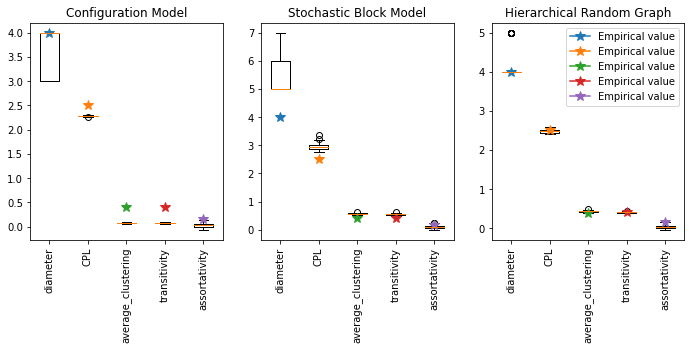

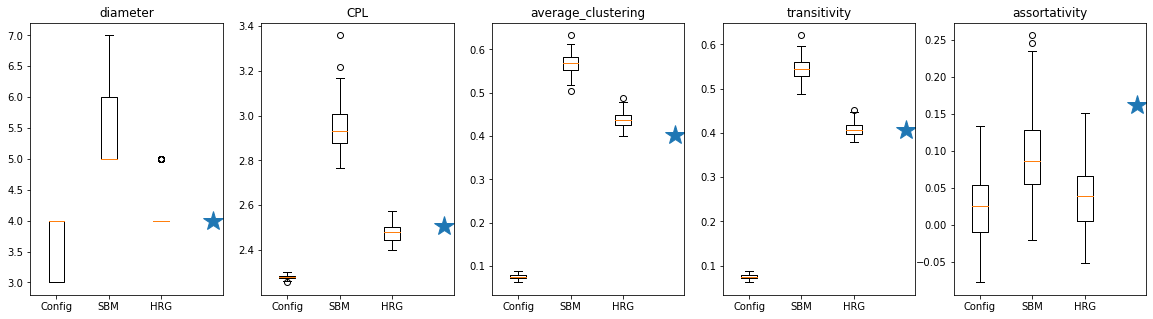

In [36]:
# Run, but do not modify the contents of this cell
util_plot_graph_statistics([graph_stats, config_stats, sbm_stats, hrg_stats])

## 2.6 <font size=3> [8 pts] Analysis

Use the visualizations above to answer the questions below.

**Question 1.** Which graph generator algorithm would you say best captures the structure of the empirical network *overall*?

In [37]:
def part_2_analysis_q1_response() -> str:
    """
    return
                  str        string that best answers the question
    """
    #return "There is a strong argument to made for each of the generation algorithms."
    #return "They are all terrible. Why did you make me do this?"
    #return "I have no opinion."
    #return "The configuration model algorithm because there is no variance among the graphs it produces for any of the statistics"
    #return "The stochastic block matrix algorithm because there is no variance among the graphs it produces for any of the statistics"
    return "The hierarchical random graph algorithm because there is no variance among the graphs it produces for any of the statistics"
#     return "Yo"

**Question 2.** Which of the following statements do you think is the most true?

In [38]:
def part_2_analysis_q2_response() -> str:
    """
    return
                  str        string that best answers the question
    """
    #return "The three algorithms seem to have the most difficulty capturing the diameter of the empirical network"
    #return "The three algorithms seem to have the most difficulty capturing the CPL of the empirical network"
    #return "The three algorithms seem to have the most difficulty capturing the average clustering of the empirical network"
    #return "The three algorithms seem to have the most difficulty capturing the transitivity of the empirical network"
    return "The three algorithms seem to have the most difficulty capturing the assortativity of the empirical network"
#     return "Yo"

# Part 3 <font size=3> [35 pts] Network estimation

This part will use a [mouse brain network](https://networkrepository.com/bn-mouse-brain-1.php). Run the cells below.

In [39]:
# Run, but do not modify the contents of this cell
def load_mouse_brain_network() -> nx.Graph:
    G = nx.read_edgelist("data/mouse_brain_data.txt", create_using=nx.Graph)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

**Unit test**

Running the cell below should show the following output:

> Graph with 213 nodes and 16089 edges

In [40]:
# Run, but do not modify the contents of this cell
G_mouse_brain = load_mouse_brain_network()
print(G_mouse_brain)

Graph with 213 nodes and 16089 edges


## 3.1 <font size=3> [10 pts] Estimate node count

In the body of the function below:
1. Implement the capture-recapture estimation method to compute the number of nodes in the network by randomly choosing samples of the sizes indicated in `sample_sizes`. Recall that the capture-recapture method involves computing two samples $n_1, n_2$ and using their intersection $n_3$ to perform the estimation.
2. For each size in `sample_sizes`, repeat the experiment `n_iter` times.
3. Store your results in a dictionary where the key is the sample size and the value is a list of the estimated network sizes for each trial. If the size of the $n_3$ set is 0, you can skip that iteration.

In [41]:
def estimate_network_size(G, sample_sizes:list=[5, 10, 50, 100], n_iter:int=100) -> dict:
    """
    params
        G                    nx.Graph
        sample_sizes         list[int]
        n_iter               int
        
    return
        results              Dict[str, List[int]]    a dictionary where key is the sample size and the value is a list of the estimated network sizes for each trial
    
        
    """

    nodes = list(G.nodes())
    results = {}

    for s in sample_sizes:
        ests = []
        for i in range(n_iter):
            s1 = set(random.sample(nodes, s))
            s2 = set(random.sample(nodes, s))
            inter = len(s1 & s2)
            if inter != 0:
                est = (len(s1) * len(s2)) / inter
                ests.append(int(est))
        results[s] = ests
    
    return results

**Unit test**

Running the cell below should produce the following output:

> `(in the range of 200-240)`

In [42]:
# Run, but do not modify the contents of this cell
sample_size = 50
results = estimate_network_size(G=G_mouse_brain, sample_sizes=[sample_size], n_iter=100)
avg = np.mean(results[sample_size])
print(f"{avg:.0f}")

220


## 3.2 <font size=3> [10 pts] Estimate edge count

In the body of the function below:
1. Estimate the number of edges using the induced subgraph sampling and Horvitz-Thompson estimator by sampling `n_sample` nodes in the network. Repeat this `n_iter` times.
2. Save the resulting edge count estimates in a list and return it.

In [43]:
def estimate_edges(G:nx.Graph, n_sample:int=50, n_iter:int=100) -> list:
    """
    params
        G                      nx.Graph
        n_sample               int
        n_iter                 int
        
    return
        estimated_edges        list[int]        a list of estimated edges
    """
    edges = list(G.edges())
    M = len(edges)
    estimated_edges = []

    for i in range(n_iter):
        sampled_edges = random.sample(edges, min(n_sample, M))
        p = len(sampled_edges) / M
        est = len(sampled_edges) / p
        estimated_edges.append(int(est))

    return estimated_edges

**Unit test**

Running the cell below should produce the following output:

> `(anywhere from 24000 up to 42000)`

In [44]:
# Run, but do not modify the contents of this cell
n_sample = 25
estimated_edges = estimate_edges(G=G_mouse_brain, n_sample=n_sample, n_iter=100)
avg = np.mean(estimated_edges)
print(f"{avg:.0f}")

16089


## 3.3 <font size=3> [0 pts] Visualizations

Run the cells immediately below to load utility functions for visualization.

In [45]:
# Run, but do not modify the contents of this cell
def util_plot_histos_as_ridge(data:list) -> None:
    data = [np.array(sublist) for sublist in data]
    fig = ridgeplot.ridgeplot(
        samples=data,
        nbins=10,
    )
    fig.update_layout(
        title="Distributions of estimated network size\nbased on sample size",
        xaxis_title="Network size estimation",
        yaxis_title="Sample size",
    )
    fig.show()
    
    return

In [46]:
# Run, but do not modify the contents of this cell
def util_plot_sample_size_error(
    results:dict, 
    true_size:int,
    sample_sizes:list=[5, 10, 25, 50, 100]
) -> None:
    means = []
    sdevs = []
    for sample_size in results:
        data = results[sample_size]
        mean, sdev = np.mean(data), np.std(data)
        means.append(mean)
        sdevs.append(sdev)

    print("util_plot_sample_size_error : len(sample_sizes) : ", len(sample_sizes))
    print("util_plot_sample_size_error : len(sample_sizes) : ", len(means))
    
    plt.errorbar(x=sample_sizes, y=means, yerr=sdevs, ecolor="#ff0000", label="Estimated size mean")
    plt.hlines(y=true_size, xmin=sample_sizes[0]-10, xmax=sample_sizes[-1]+10, colors="#d1ac3d", label="Actual size")
    plt.xlabel("Sample Size")
    plt.ylabel("Node Count")
    plt.title("Estimated Node Count Means and Error")
    plt.legend()
    plt.show()

Run the cell immediately below to run the functional tools developed above and collect sample data.

In [47]:
# Run, but do not modify the contents of this cell

# Load mouse brain network
G_mouse_brain = load_mouse_brain_network()

# Setup parameters
n_iter=100
sample_sizes=[5*i for i in range(1,40)]

# Estimate node count
network_size_estimates = estimate_network_size(G=G_mouse_brain, sample_sizes=sample_sizes, n_iter=n_iter)

Run the cells below to see the following visualizations:
1. A ridge plot of network size estimate *distributions*, based on sample size,
2. A plot of network size *error* estimates, based on sample size.

In [48]:
# Run, but do not modify the contents of this cell
G_mouse_brain = load_mouse_brain_network()
sub_sample_sizes=[25, 50, 75, 100]
data = []
for sample_size in sub_sample_sizes:
    data.append(network_size_estimates[sample_size])
util_plot_histos_as_ridge(data=data)

util_plot_sample_size_error : len(sample_sizes) :  39
util_plot_sample_size_error : len(sample_sizes) :  39


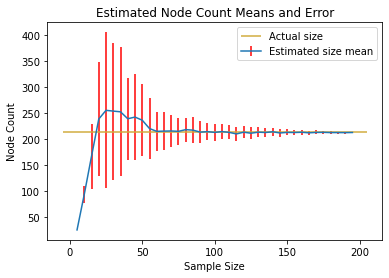

In [49]:
# Run, but do not modify the contents of this cell
util_plot_sample_size_error(
    network_size_estimates, 
    sample_sizes=sample_sizes, 
    true_size=len(G_mouse_brain.nodes())
)

## 3.4 <font size=3> [10 pts] Analysis

Use the visualizations above to answer the questions below.

**Question 1.** How does the estimate of the network size change as the sample size is increased?

In [50]:
def part_3_analysis_q1_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "It oscillates wildly and never converges."
    #return "The error bars generally shrink, but the distributions expand, becoming less useful."
    #return "The distributions converge to a normal distribution, but the error bars expand."
    #return "Both the error bars expand and the distribution diverge from normal distributions."
    return "The error bars generally shrink and the distributions converge to a normal distribution."
#     return "Yo"

**Question 2.** What is the smallest sample size you would consider a good
choice for estimating the number of nodes?

In [51]:
def part_3_analysis_q2_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "A sample size of 5 would do just fine."
    #return "A sample size of 10, or 5% of the entire network, seems plenty reasonable."
    return "A sample size of 75 seems to be a decent balance between not too large of a percentage of nodes, but with decent accuracy."
    #return "Something close to 90% of the total nodes should probably do it."
    #return "Just take the whole network for the sample."
#     return "Yo"

# Part 4 <font size=3> [15 pts] Natural language processing with label propagation

For this part, we will pretend that there are two political parties, characterized as follows:
* **Orange Party**
    * pro-worker rights
    * pro-technology-for-all
    * anti-idleness.
* **Green Party**
    * pro-individual autonomy
    * off-grid/nature life
    * eco-conscious
    * pro-self-reliance

We want to build a machine learning natural language classifier that can accurately predict which party any given political statement should be ascribed to. For example, does the following statement sound like it would be said by someone from the Orange Party, or from the Green Party?

> "autonomy isnt free its forgers only"

In order to do this, we will create a bipartite natural language network and use it to train a sentence classifier model using a semi-supervised machine learning algorithm called [label propagation](https://en.wikipedia.org/wiki/Label_propagation_algorithm). 

## 4.1 <font size=3> [1 pts] Corpus network

Our goal is to build a natural language network from a corpus of political statements. The end result will be a matrix that we can think of as a biadjacency matrix between documents (sentences) on one side and single words on the other. Run the cell below to see a toy example of this.

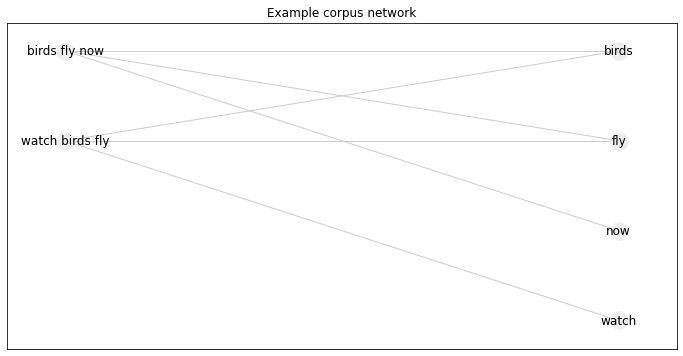

In [52]:
# Run, but do not modify the contents of this cell
G_corpus_network = nx.Graph()
G_corpus_network.add_edges_from(nlp_data.corpus_network_example_edges)
plt.figure(figsize=(12,6))
nx.draw_networkx(
    G=G_corpus_network,
    pos=nlp_data.corpus_network_example_pos, 
    with_labels=True, 
    node_color="#eeeeee", 
    edge_color="#cccccc")
plt.title("Example corpus network")
plt.show()

The above example was a toy with just a few sentences. Now we will create the network for the entire political statement corpus. 

In the body of the function below:
1. Iterate through `nlp_data.corpus_poli_labelled`, which is a list of 2-tuples `(doc, label)`,
    * storing each document (sentence) in `docs`,
    * parsing the document into individual words, storing each *unique* word in `words`,
    * storing the label (0 or 1) in `labels`.
    * for each word parsed out from the document, add an edge from the document to the word
1. Reduce the `words` list down a list containing only unique words.
2. Use the python string `sort` method to sort `words`
3. Return the graph, docs list (not sorted), word list (sorted), and label list (not sorted).

In [53]:
def get_corpus_network() -> nx.Graph:
    """
    return
        G_corpus          nx.Graph
        docs              list[str]
        words             list[str]
        labels            list[int]
    """
    
    G_corpus = nx.Graph()
    docs = []
    words = set()
    labels = []
    
    for d, l in nlp_data.corpus_poli_labelled:
        docs.append(d)
        labels.append(l)
        word_list = d.split()
        for w in word_list:
            words.add(w)
            G_corpus.add_edge(d, w)

    words = sorted(words)
    return G_corpus, docs, words, labels

**Unit test**

Running the cell below should produce the following output:

> `Graph with 1007 nodes and 2002 edges`

In [54]:
# Run, but do not modify the contents of this cell
G_corpus, docs, words, labels = get_corpus_network()
print(G_corpus)

Graph with 1007 nodes and 2002 edges


**Unit test**

Running the cell below should produce the following output:

> `density                  :  0.0040`
> 
> `is bipartite             :  True`
>
> `total node count         :  1007`
>
> `doc count                :  369`
>
> `word count               :  638`
>
> `biadjacency_matrix shape :  (369, 638)`

In [55]:
# Run, but do not modify the contents of this cell
G_corpus, docs, words, labels = get_corpus_network()
B_corpus = nx.bipartite.biadjacency_matrix(G_corpus, row_order=docs, column_order=words)
print("density                  : ", f"{nx.density(G_corpus):.4f}")
print("is bipartite             : ", nx.is_bipartite(G_corpus))
print("total node count         : ", len(list(G_corpus.nodes)))
print("doc count                : ", len(docs))
print("word count               : ", len(words))
print("biadjacency_matrix shape : ", B_corpus.shape)

density                  :  0.0040
is bipartite             :  True
total node count         :  1007
doc count                :  369
word count               :  638
biadjacency_matrix shape :  (369, 638)


C:\Users\yeyan\AppData\Local\Temp\ipykernel_13356\3228020880.py:3: FutureWarning:

biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0



## 4.2 <font size=3> [2 pts] Biadjacency matrix of corpus network

In this sub part, we will *vectorize* each document (sentence) in a corpus of text data. That is, we will convert each document into a row vector, with a number of entries equal to the number of distinct tokens (words) in the entire corpus. Stacking these rows gives us a $m\times n$ matrix, where $m$ is the number of documents and $n$ is the number of unique words. This is precisely the biadjacency matrix of the corpus network discussed in the prior sub part, except that there are weights based on *cosine similarity*.

In the body of the function below: 
1. Use sklearn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class and its `fit_transform` method to convert the text_data into a $m\times n$ matrix, where:
    * $m$ is the number of documents in the `text_data` corpus (each string is considered a document).
    * $n$ is the number of unique words (after lower case normalization) among all documents in the `text_data` corpus. These individual words are in [lexicographpical order](https://en.wikipedia.org/wiki/Lexicographic_order).
2. Return the vectorization (ie, the computed matrix)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_corpus_biadjacency_matrix(text_data:list) -> np.array:
    """
    params
        text_data      list              list of strings (each string called a 'document')
    
    return
        B              NumPy array       a m x n matrix, where
                                         m is the number of documents in text_data
                                         n is the total number of distinct words in text_data
                                              (in lexicographical order)
                                         X[i,j] is the cosine similarity between
                                               the i-th document, and
                                               the j-th single word
    """

    B = TfidfVectorizer(lowercase=True).fit_transform(text_data)    
    return B

**Unit test 1**

Running the cell below should show the following output:

> `0.6228`

In [57]:
# Run, but do not modify the contents of this cell
text_data = ["Yo world","Yo hey there", "Hello world",]
B_example = get_corpus_biadjacency_matrix(text_data)
print(f"{B_example[1,1]:.4f}")

0.6228


**Unit test 2**

Running the cell below should show the following output:

> `[[0.50154891 0.50154891 0.70490949 0.        ]`
>
> `[0.50154891 0.50154891 0.         0.70490949]]`

In [58]:
# Run, but do not modify the contents of this cell
text_data = ["birds fly now", "watch birds fly"]
B_example = get_corpus_biadjacency_matrix(text_data).toarray()
print(B_example)

"""
The structure of this matrix is as follows:

                              word_0   word_1  word_2   word_3
                               birds      fly     now    watch
doc_0 : "birds fly now"        0.502    0.502   0.705    0.000
doc_1 : "watch birds fly"      0.502    0.502   0.000    0.705

"""

pass

[[0.50154891 0.50154891 0.70490949 0.        ]
 [0.50154891 0.50154891 0.         0.70490949]]


**Unit test 3**

Running the cell below should show the following output:

> `docs : words   :  (369, 638)`
>
> `B_corpus.shape :  (369, 632)`

Notice that this these are the same$^1$ dimensions as the document and word counts that we found in the corpus network.

$^1$ Almost! There are slightly fewer individual words. This is because the TdidfVectorizer method discards some words that it deems to hold too little distinguishing information to be worth tracking through the process.

In [59]:
# Run, but do not modify the contents of this cell

# Corpus network as a networkx graph 
G_corpus, docs, words, labels = get_corpus_network()

# Corpus network biadjacency matrix
documents = [doc for doc, label in nlp_data.corpus_poli_labelled]
B_corpus = get_corpus_biadjacency_matrix(documents)

# Comparison
print("docs : words   : ", (len(docs), len(words)))
print("B_corpus.shape : ", B_corpus.shape)

docs : words   :  (369, 638)
B_corpus.shape :  (369, 632)


## 4.3 <font size=3> [2 pts] Get text data and labels

In the body of the function below:
1. Extract a random sample of 2-tuples from the `nlp_data.corpus_poli_labelled` list. The sample size should be proportional to the `perc_of_corpus` float. If the float is `0.5`, then 50% of the 2-tuples should be extracted. Shuffle the new list of extracted 2-tuples.
2. Separate the random sample into `text_data` and `labels_true` lists and return them.

In [60]:
def get_training_text_and_labels(perc_of_corpus:float=0.5) -> list:
    """
    params
        perc_of_corpus      float          the percentage of the corpus that will be extracted
                                               0.25 would be 25% of the corpus
    return
        text_data           list           list of strings
                                               each string is a document from the corpus module
        labels_true         list           list of integers containing 
                                                the fictional party attribution label
    """
    
    size = int(len(nlp_data.corpus_poli_labelled) * perc_of_corpus)
    sample = random.sample(nlp_data.corpus_poli_labelled, size)
    random.shuffle(sample)
    text_data = [d for d, i in sample]
    labels_true = [l for i, l in sample]
    return text_data, labels_true

**Unit test**

Running the cell below should show the following output:

> `92`

In [61]:
# Run but do not modify the contents of this cell
text_data, labels_true = get_training_text_and_labels(perc_of_corpus=0.25)
print(len(text_data))

92


## 4.4 <font size=3> [2 pts] Scrubbing labels

For this function, we'll develop a means of scrubbing labels so that we can provide the label propagtion algorithm a partially labeled dataset - and then compare its predictions to the actual labels.

In the body of the function below:
1. Randomly change a number of labels in `labels_true` to -1 (neither party). The number of labels is based on the parameter `perc_unscrubbed`. If this parameter is 0.5, then 50% of the labels should be changed from the ground truth values to -1 (with 50% remaining unchanged). If this parameter is 0.25, then 75% of the labels should be changed from ground truth values to -1 (with 25% remaining unchanged). Which exact labels should be changed should be randomized.
    * Make sure that there is always at least one unscrubbed label. In the case where perc_unscrubbed=0.0 or another float small enough to round to 0.0, let the first label be left unscrubbed.
3. Return the new list as a numpy array with the indicated number of labels changed.

In [62]:
def scrub_labels(perc_unscrubbed:float=0.1, labels_true:list=[]) -> list:
    """
    params
        perc_unscrubbed         float           percentage of ground true labels that
                                              will remain unchanged
        labels_true             list            list of ground truth topological labels for
                                              some set of documents
    return
        labels_scrubbed         np.array        list of labels where perc_unscrubbed
                                              of the labels have been "scrubbed"
                                              (ie, changed from ground truth label, to a
                                                 default -1)
        
    """
    
    labels_scrubbed = copy.deepcopy(labels_true)
    size = len(labels_scrubbed)
    unscrubbed = int(round(size * perc_unscrubbed))

    if unscrubbed < 1:
        unscrubbed = 1
        unscrubbed_idxs = [0]
    else:
        unscrubbed_idxs = random.sample(range(size), unscrubbed)

    for i in range(size):
        if i not in unscrubbed_idxs:
            labels_scrubbed[i] = -1

    return np.array(labels_scrubbed)

**Unit test**

Running the cell below should show the following output:

> `[ 0 -1 -1 -1]`

In [63]:
# Run but do not modify the contents of this cell
labels_scrubbed = scrub_labels(perc_unscrubbed=0.0, labels_true=[0,0,0,0])
print(labels_scrubbed)

[ 0 -1 -1 -1]


## 4.5 <font size=3> [2 pts] Training label propagation model

Label propagation is a graph-based, **semi**-supervised machine learning technique. 
* The semi-supervision stems from the fact that some of the data is labeled and some is not. In our example, some of the documents will have their true labels (0 if they are attributed to the fictitious Orange Party and 1 if attributed to the fictitious Green Party), while others will have "no label" (the label of -1).
* Label propagation works by iteratively propagating labels from the labeled nodes to the unlabeled nodes over the graph. The propagation is determined by the weight/strength of the respective edges. In our case, the strength of the edges is determined by the cosine similarity between the single word nodes and the multi word nodes in the corpus network.

In the body of the function below:
1. Use the `get_corpus_biadjacency_matrix` function to retrieve the biadjacency matrix of the `text_data` parameter.
2. Instantiate a [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) object. To guarantee convergence, set the maximum iterations to 10,000.
3. Fit the label propagation object to the vectorized text data and the scrubbed labels.
4. Return the fit model

In [64]:
def get_trained_label_prop_model(text_data:list, labels_scrubbed:np.array) -> LabelPropagation:
    """
    params
        text_data              list[str]
        labels_scrubbed        list[int]

    return
        label_prop_model       LabelPropagation

    """

    B = get_corpus_biadjacency_matrix(text_data).toarray()
    label_prop_model = LabelPropagation(max_iter=10000)
    label_prop_model.fit(B, labels_scrubbed)

    return label_prop_model

**Unit test**

Running the cell below should show the following output:

> `[1 1]`

In [65]:
# Run, but do not modify the contents of this cell
text_data = [
    "a future worth building takes work",
    "abundance begins with enough",
    ]
labels_scrubbed = [-1,1]
label_prop_model = get_trained_label_prop_model(text_data=text_data, labels_scrubbed=labels_scrubbed)
B = get_corpus_biadjacency_matrix(text_data=text_data)
print(label_prop_model.predict(B))

[1 1]


## 4.6 <font size=3> [2 pts] Model accuracy

In the body of the function below:
1. Get the biadjacency matrix of the `text_data` and feed it into the `label_prop_model`'s `predict` method to return a list of labels for the senttences of the `text_data`.
2. Compare the list of predicted labels to the true labels and return the ratio as a real number (inclusively) between 0 and 1.

In [66]:
def get_accuracy(label_prop_model:LabelPropagation, text_data:list, labels_true:list, show:bool=False) -> float:
    """
    params
        label_prop_model      LabelPropagation
        text_data             list[str]
        labels_true           list[int]
        show                  bool
    return
        acc                   float
    """

    B = get_corpus_biadjacency_matrix(text_data)
    preds = label_prop_model.predict(B)
    num = sum(p == t for p, t in zip(preds, labels_true))
    acc = num / len(labels_true)

    if show:
        print(f"Predicted: {preds}")
        print(f"True:      {labels_true}")
        print(f"Accuracy:  {acc:.4f}")

    return acc

## 4.7 <font size=3> [2 pts] Putting it all together

In the body of the function below:
1. Use the `get_text_data_and_labels` function to get `text_data` and `y_true` based on the arguments of the function.
2. Use the `scrub_labels` function to get `y_scrubbed` based on the arguments of the function.
3. Use the `get_trained_label_prop_model` to get a trained label propagation model.
4. Use the `get_accuracy` function to get an accuracy based on the earlier returns within the function.
5. (Optional) Use the `show` parameter to display the accuracy for yourself.
6. Return the accuracy (as a real number between 0 and 1).

In [67]:
def run_full_label_prop(
    perc_of_corpus:float=0.1,
    perc_unscrubbed:float=0.25,
    show:bool=False,
) -> float:
    """
    params
        perc_of_corpus            float
        perc_unscrubbed           float
        show                      bool
    return
        acc                       float

    """

    text_data, labels_true = get_training_text_and_labels(perc_of_corpus)
    labels_scrubbed = scrub_labels(perc_unscrubbed, labels_true)
    label_prop_model = get_trained_label_prop_model(text_data, labels_scrubbed)
    acc = get_accuracy(label_prop_model, text_data, labels_true, show=show)
    return acc

**Unit test**

> `number of documents : 92`
>
> `number of unique labels : 2`
>
> `acc : (about 60-85%)`

In [68]:
# Run, but do not modify the contents of this cell
perc_of_corpus = 0.25
perc_unscrubbed = 0.25
acc = run_full_label_prop(
    perc_of_corpus=perc_of_corpus, 
    perc_unscrubbed=perc_unscrubbed, 
    show=True,
)

Predicted: [1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0
 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
True:      [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Accuracy:  0.7826


## 4.8 <font size=3> [0 pts] Visualization

Run the cell below to define a visualization function.

In [69]:
# Run, but do not modify the contents of this cell
def util_show_label_prop_accuracy(
    perc_of_corpus_min=0.1, 
    perc_of_corpus_max=1.0, 
    perc_of_corpus_ct=10,
    perc_unscrubbed_min=0.3,
    perc_unscrubbed_max=0.75,
    perc_unscrubbed_ct=10,
) -> None:

    perc_of_corpus_space = np.linspace(start=perc_of_corpus_min, stop=perc_of_corpus_max, num=perc_of_corpus_ct)
    perc_unscrubbed_space = np.linspace(start=perc_unscrubbed_min, stop=perc_unscrubbed_max, num=perc_unscrubbed_ct)

    H = np.zeros(shape=(perc_of_corpus_ct, perc_unscrubbed_ct))

    for i in range(perc_of_corpus_ct):
        perc_of_corpus = perc_of_corpus_space[i]
        for j in range(perc_unscrubbed_ct):
            perc_unscrubbed = perc_unscrubbed_space[j]

            H[i,j] = run_full_label_prop(perc_of_corpus=perc_of_corpus, perc_unscrubbed=perc_unscrubbed, show=False)

    # Visualize H matrix (accuracy matrix) as heatmap
    sns.heatmap(H,vmin=0.0, vmax=1.0)
    plt.title("Performance of Label Propogation algorithm")
    plt.xlabel(f"Percentage of true labels\nmin={perc_unscrubbed_min}  max={perc_unscrubbed_max}")
    plt.ylabel(f"Percentage of corpus\nmin={perc_of_corpus_min}  max={perc_of_corpus_max}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

Run the cell below to see one or more heatmap visualizations. Use the visualizations to answer the questions in the next sub part.

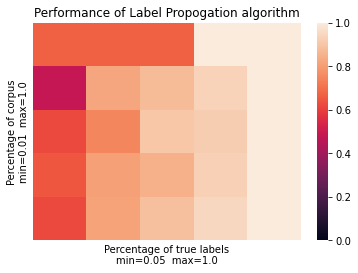

In [70]:
util_show_label_prop_accuracy(
    perc_of_corpus_min=0.01, 
    perc_of_corpus_max=1.0, 
    perc_of_corpus_ct=5,
    perc_unscrubbed_min=0.05,
    perc_unscrubbed_max=1.0,
    perc_unscrubbed_ct=5,
)

## 4.9 <font size=3> [2 pts] Analysis

Use the visualizations above to answer the questions below.

**Question 1.** Of the following two factors, which one does the label propagation algorithm seem most sensitive to - and why?
* Percentage of true labels available
* Percentage of corpus used

In [71]:
def part_4_analysis_q1_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "percentage of true labels available because more words is always better"
    return "percentage of true labels available because the algorithm will have proportionally more true data to work with"
    #return "percentage of true labels available because the algorithm has to have all the labels since it is a supervised learning algorithm"
    #return "percentage of corpus used because because more words is always better"
    #return "percentage of corpus used because because the algorithm will have more words to work with"
    #return "percentage of corpus used because just ike a LLM, label propagation needs a ton of training data"
#     return "Yo"

# Part 5 <font size=3> [15 pts] NLP with a Graph Attention Network (GAT)

### Sentence classification <font size=3> vA : Using a single large, sparse network

In the prior part, we constructed a *single* network from a corpus of documents/sentences. The network was bipartite, with one node set being the individual documents/sentences, and the other being the set of all single words found in the corpus. We saw that the network was very sparse, with less than 1% of the total number of possible edges.

We trained a sentence classification model on the single, large, corpus network using the semi-supervised machine learning algorithm called label propagation to perform the task of sentence classification. In particular, we trained the model to identify politically-themed statements as being attributed to one of two fictitous political parties (the Orange Party and the Green Party).

### Sentence classification <font size=3> vB : Using many small networks and one moderately-sized, highly connected network

In this part, we will use a Graph Attention Network (GAT) - a type of Graph Neural Network (GNN) - to also perform sentence classification, but with our GAT, we'll be able to leverage new geometry, namely:
* the graph structure of sentences, and
* an attention mechanism that will allow words to more directly influence one another.

Instead of classifying politically-themed statements according to political party, in this part we will classify sentences according to *grammatical mood*. There are four grammatical moods (declarative/statement, interrogative/question, imperative/command, and exclamatory/exclamation). We will focus just on the first three. We will assign labels in the following way:
* 0: imperative/command
* 1: interrogative/question
* 2: declarative/statement

## 5.1 <font size=3> [3 pts] Tokenization

In the body of the function below:
1. Convert the sentence string to all lower case using `lower` (a python `str` class method).
2. Strip out any ending punctuation such as period, question mark, or exclamation point using `rstrip` (a python `str` class method).
3. Split the sentence over spaces using `split` (a python `str` class method).

In [72]:
def get_sentence_tokenized(sentence:str) -> list:
    """
    params
        sentence           str
    return
        sentence_copy      list[str]
    """

    sentence_copy = sentence.lower().rstrip(".!?").split()
    return sentence_copy

**Unit test**

Running the cell below should yield the following output:

> `['hey', 'get', 'off', 'my', 'lawn']`

In [73]:
# Run, but do not modify the contents of this cell
sentence = "Hey get off my lawn!"
sentence_tokenized = get_sentence_tokenized(sentence=sentence)
print(sentence_tokenized)

['hey', 'get', 'off', 'my', 'lawn']


In the body of the function below:
1. Access `nlp_data.GAT_corpus_with_labels` and unzip into one list of sentences and one list of labels.
2. Generate:
    * a list `tokenized` of tokenized sentences.
    * a set `vocab` (sorted lexicographically) of words found among the sentences.
    * a dictionary `word2idx` where the keys are the individual words of the vocabulary and the values are unique indices
3. Return these generated items

In [74]:
def get_tokenized_sentences_and_labels():
    """
    return
        tokenized         list[list[str]]
        labels            list[int]
        word2idx          dict[str,int]
    """
    
    sentences, labels = zip(*nlp_data.GAT_corpus_with_labels)
    tokenized = [get_sentence_tokenized(s) for s in sentences]
    vocab = sorted(set(word for sentence in tokenized for word in sentence))
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return tokenized, list(labels), word2idx

**Unit test**

Running the cell below should yield the following output:

> `['put', 'a', 'hat', 'on', 'the', 'cat']`
>
> `0`
>
> `7`

In [75]:
# Run, but do not modify the contents of this cell
tokenized, labels, word2idx = get_tokenized_sentences_and_labels()
print(tokenized[3])
print(labels[3])
print(word2idx['the'])

['put', 'a', 'hat', 'on', 'the', 'cat']
0
7


## 5.2 <font size=3> [2 pts] Word embeddings

Neural networks require numerical input, so we need a way to convert words into numerical objects. We do this in two stages:
1. **Stage 1. One-hot encoding.** We assign to each word $w$, a vector $v_1 = \begin{bmatrix} 0 & \cdots & 0 & 1 & 0 & \cdots & 0 \end{bmatrix}$ where the vector is all zeros except for a 1 in the $j$-th position, where the word is the $j$-th word in the vocabulary.
2. **Stage 2. Embedding into $n$-dimensional space.** We choose a dimension $n\in\mathbb{N}$ and assign each vector $v_1$ to a corresponding vector in $v_2\in\mathbb{R}^n$. Usually, the embedding dimension $n$ is far smaller than the number of words in the corpus.

There is a canonical way to perform a one-hot encoding on any vocabulary. Thus, any decision related to am word embedding comes from 
* the choice of embedding dimension $n$, and
* the specific assignment of one-hot-encoded word vectors $v_1$ to elements $v_2\in\mathbb{R}^n$.

Thus, all the information about a word embedding is stored in the linear transformation (ie, matrix) $E = \mathbb{R}^m\rightarrow \mathbb{R}^n$. Whenever we reference a word embedding (or just *embedding* for short) in this context, we will usually be referring to the matrix $E$ in particular.

The specific computational structure we use for the matrix $E$ is a torch tensor. But to keep things simple and focus more on the core concepts of this course, we provide a utlity function that returns the embedding matrix. Run the cell below to store the function in the kernel.

In [76]:
def util_get_word_embedding(word2idx, embedding_dim:int=2):
    vocab = list(word2idx.keys())
    embedding = torch.rand((len(vocab), embedding_dim))
    return embedding

**Unit test**

Running the cell below should yield the following output:

> `torch.Size([4, 3])`

In [77]:
# Run, but do not modify the contents of this cell
word2idx = {"hello":0, "the":1, "to":2, "world":3}
embedding_dim = 3
embedding = util_get_word_embedding(word2idx=word2idx, embedding_dim=embedding_dim)
print(embedding.shape)

torch.Size([4, 3])


In a machine learning context, the embedding dimension is a *hyperparameter.* When we actually train our GAT model, we'll set it to be around 16. However, for the next couple of sections, we will set it at low-dimension for the sake of developing our intuition. Specifically, note that 2-dimensional vectors can be visualized as points in a 2-dimensional plane.

Run the cell below, to see a visualization of words from the vocabulary we will be using being embedded into $\mathbb{R}^2$.

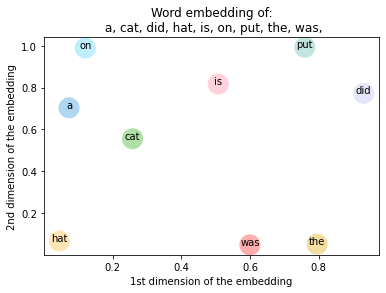

In [78]:
# Utility function
def util_show_word_embedding_2d(word2idx, color=False) -> None:

    embedding = util_get_word_embedding(word2idx=word2idx, embedding_dim=2)
    embedding_matrix = embedding.numpy()

    x_coords = embedding_matrix[:,0]
    y_coords = embedding_matrix[:,1]
    
    words = list(word2idx.keys())

    c=[]
    for i in range(len(words)):
        color_to_add = "#dddddd"
        if color:
            color_to_add = nlp_data.colors[i%len(words)]
        c.append(color_to_add)
    
    plt.scatter(x_coords, y_coords, s=400, c=c) # Plot the points
    
    for i, txt in enumerate(words):
        plt.text(x_coords[i], y_coords[i], txt, fontsize=10, ha='center')

    words_str = ""
    for word in words:
        words_str += " " + word +","
    
    plt.xlabel('1st dimension of the embedding')
    plt.ylabel('2nd dimension of the embedding')
    plt.title('Word embedding of:\n'+words_str)
    plt.show()

    plt.show()

tokenized, labels, word2idx = get_tokenized_sentences_and_labels()
util_show_word_embedding_2d(word2idx=word2idx, color=True)

In the body of the function below:
1. Convert the embedding - of `torch.tensor` type - to a numpy `ndarray`.
2. Then return the proper row or column of the coverted embedding that corresponds to the embedding vector associated to the word.

In [79]:
def get_word_vec(word:str, word2idx:dict, embedding:torch.tensor) -> np.array:
    """
    params
        word              str
        word2idx          dict[str,int]
        embedding         torch.tensor
    return
        word_vec          np.array
    """

    idx = word2idx[word]
    embedding_np = embedding.numpy()
    word_vec = embedding_np[idx]
    
    return word_vec

**Unit test**

Running the cell below should yield the following output:

> `[0.3   0.728]`

In [80]:
# Run, but do not modify the contents of this cell
word2idx = {"a":0, "cat":1, "did":2, "hat":3, "is":4, "on":5, "put":6, "the":7, "was":8,}
embedding = torch.tensor([
    [0.0, 0.7280],
    [0.1, 0.7280],
    [0.2, 0.7280],
    [0.3, 0.7280],
    [0.4, 0.7280],
    [0.5, 0.7280],
    [0.6, 0.7280],
    [0.7, 0.7280],
    [0.8, 0.7280],
])
word_vec = get_word_vec(word="hat", word2idx=word2idx, embedding=embedding)
print(word_vec)

[0.3   0.728]


## 5.3 <font size=3> [2 pts] Node features

For our purposes, from any corpus of natural language data, the first step is to embed the individual words that make up the corpus into some $n$-dimensional space. So that we could visualize how this works, we did an example set of word embeddings into 2-dimensional space. However, just 2 dimensions is pretty tight. Thought of another way, each word only has 2 features, which - for those of you who know much about machine learning - is probably too few features to be able to train useful models for this classification task. What should we do then?

One answer is increase the number of features (ie, the embedding dimension). Generally speaking, the greater the dimension, the greater then number of hidden characteristics of the data that a machine learning model can learn. 

Suppose we want to increase the embedding dimension to 8 so that we have 8 features per word. That seems good, but now how do visualize that? Something we *don't* do is to try to visualize the points sitting in 8-dimensional space, because we can't. Our ability to visualize generally stops at dimension 3 (or 4, maybe 5 if you've practiced a lot). So now, instead of letting a node's visual placement in $R^n$ tell us what it's features are, instead, we'll show a list/vector of feature values as part of the node name. Run the cell below to see conceptually how this works.

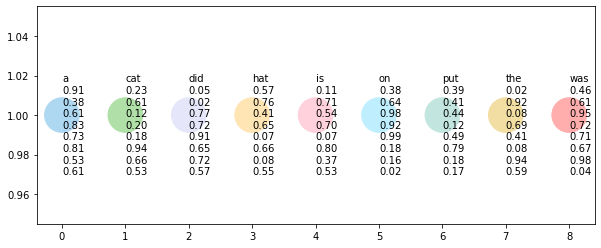

In [81]:
# Utility function
def util_show_word_embedding_as_features(word2idx, embedding_dim:int=16) -> None:

    plt.figure(figsize=(10,4))
    
    x = [word2idx[word] for word in word2idx]
    y = np.ones(shape=(len(x),))
    embedding = util_get_word_embedding(word2idx=word2idx, embedding_dim=embedding_dim)
    embedding_matrix = embedding.numpy()

    c = nlp_data.colors[:len(x)]
    plt.scatter(x=x, y=y, c=c, s=1200)

    words = list(word2idx.keys())
    for i, txt in enumerate(words):
        for j in range(embedding_matrix.shape[1]):
            txt += "\n" + "{:.2f}".format(embedding_matrix[i,j])
        plt.text(x[i], y[i]-0.03, txt, fontsize=10, ha='left')
    
    plt.show()

tokenized, labels, word2idx = get_tokenized_sentences_and_labels()
util_show_word_embedding_as_features(word2idx, embedding_dim=8)

In the body of the function below, choose the statement that best answers the question:

**Question:** If the size of a vocabulary is 37 unique words and the embedding dimension is 14, how many features will each word node have?

In [82]:
def part_5_node_feature_q_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "37 since each word gets a feature for each word and itself"
    return "14 since the embedding dimension gives one feature per coordinate in R^{14}"
    #return "51 since 51 = 37 + 14, where each node gets a feature per word and a feature per dimension in R^{14}"
    #return "23 since 23 = 37 - 14, where the only valuable features are those than can be applied to words more than the embedding dimension"
    #return "518 since 518 = 37 * 14, where each node gets one feature per element in the embedding tensor/matrix"
    #return "2 since 37/14 approx 2.62, where each feature represents the compression of the vocabulary down into a 14-dimensional real space"
#     return "Yo"

## 5.4 <font size=3> [3 pts] Message passing pt 1

As cool as this in of itself, we haven't even gotten to the best part - the graphs! Any graph neural network uses the structure of a graph in order to learn. In particular, it does this through the act of **message passing**. Simply, this is process of nodes iteratively sharing information about their features with their neighbors. 

You can think of this as all the nodes iteratively passing each other messages back and forth over a series of discrete time steps. After one time step, a node will have received messages from their neighbors (those nodes that are 1 edge-hop away). After two time steps, a node will have received a message from each of their *neighbors'* neighbors (2 edge-hops away). Following another time step, they will have received a message from their neighbor's neighbor's neighbors (3 edge-hops away). Increase the time step yet again and...well, you get the idea.

In the body of the function below:
1. Construct a graph based on the passed `sentence` and `word2idx`. For each word in the sentence, add a node to an undirected graph with node name the index of the word from word2idx. Then for each pair of successive words in the sentence, add an edge between their respective indices in the graph. For example, if the sentence was "the cat in the hat", there would be the following edges:
    * an edge between the index of "the" and the index of "cat"
    * an edge between the index of "cat" and the index of "in"
    * an edge between the index of "in" and the index of "the"
    * an edge between the index of "the" and the index of "hat'
2. Once the graph is constructed, add a node attribute with name `"features"` to each node that is the respective row from the embedding matrix that represents the nodes features/$n$-dimensional embedding vector.
3. Return the constructed graph

In [83]:
def get_sentence_idx_graph(sentence:str, word2idx:dict, embedding_matrix:np.array) -> nx.Graph:
    """
    params
        sentence              str
        word2idx              dict[str,int]
        embedding_matrix      np.array
    return
        G_idxs                nx.graph
    """

    G_idxs = nx.Graph()
    words = sentence.lower().rstrip(".!?").split()

    for i, w in enumerate(words):
        idx = word2idx[w]
        if not G_idxs.has_node(idx):
            G_idxs.add_node(idx)
        if i > 0:
            prev = word2idx[words[i - 1]]
            G_idxs.add_edge(prev, idx)

    for node in G_idxs.nodes():
        G_idxs.nodes[node]['features'] = embedding_matrix[node]

    
    return G_idxs

**Unit test**

Running the cell below should yield the following output:

> `[0.6   0.728]`

In [84]:
# Run, but do not modify the contents of this cell
sentence = "put the hat on the cat"
word2idx = {"a":0, "cat":1, "did":2, "hat":3, "is":4, "on":5, "put":6, "the":7, "was":8,}
embedding = torch.tensor([
    [0.0, 0.7280],
    [0.1, 0.7280],
    [0.2, 0.7280],
    [0.3, 0.7280],
    [0.4, 0.7280],
    [0.5, 0.7280],
    [0.6, 0.7280],
    [0.7, 0.7280],
    [0.8, 0.7280],
])
embedding_matrix = embedding.numpy()
G_idx = get_sentence_idx_graph(
    sentence=sentence, 
    word2idx=word2idx, 
    embedding_matrix=embedding_matrix
)
print(nx.get_node_attributes(G_idx,"features")[6])

[0.6   0.728]


Message passing is an iterative process on a graph involving all nodes in that graph at each iteration. This can be a little tricky to visualize, but if we stick to the small graph of a single sentence, we should be able to come up with something nice.

The embedding matrix holds all the feature information for nodes, but message passing requires graph-level information - in particular, which words are the neighbors of a given word.

In the body of the function below:
1. Use the `get_sentence_idx_graph` function to get a sentence graph.
2. Construct a *new* embedding matrix where the $i$-th row of the new embedding matrix is
    * the same as the $i$-th row of the argument `embedding_matrix` if $i$ is not the index of a word node in the sentence graph, and
    * otherwise, is the vector sum $\textbf{v}_i + \omega * \sum_{k \text{ nbr of } i }(\textbf{v}_k - \textbf{v}_i)$, where $\textbf{v}_i$ is the $i$-th row/feature vector of the embedding matrix, and $\textbf{v}_k$ is the row/feature vector of a neighbor $k$ of $i$. The sum is done over all neighbors of $i$. Note that this information needs to be stored in the *new* matrix.

In [85]:
def message_pass_on_embedding_matrix(sentence, word2idx, embedding_matrix, msg_weight=0.2):
    """
    params
        sentence                  str
        word2idx                  dict[str,int]
        embedding_matrix          np.array
        msg_weight                float
    return
        embedding_matrix_new      np.array
    """
    
    G = get_sentence_idx_graph(sentence, word2idx, embedding_matrix)
    embedding_matrix_new = np.zeros_like(embedding_matrix)

    for i in range(embedding_matrix.shape[0]):
        if i in G.nodes:
            vi = embedding_matrix[i]
            neighs = list(G.neighbors(i))
            if neighs:
                neighbor_sum = sum(embedding_matrix[k] - vi for k in neighs)
                embedding_matrix_new[i] = vi + msg_weight * neighbor_sum
            else:
                embedding_matrix_new[i] = vi
        else:
            embedding_matrix_new[i] = embedding_matrix[i]
    
    return embedding_matrix_new

Run the cell below to setup a utility function for visualizing message passing.

In [86]:
# Utility function
def util_show_message_passing(
    sentence, 
    word2idx, 
    embedding_matrix, 
    msg_weight=0.2,
    num_iter=3,
):

    # Get sentence graph
    G_idxs = get_sentence_idx_graph(
        sentence=sentence, 
        word2idx=word2idx, 
        embedding_matrix=embedding_matrix
    )

    plt.figure(figsize=(8, 6))
    pos = nx.kamada_kawai_layout(G_idxs)

    # Draw text on the graph showing the words associated with the node index
    for idx in list(G_idxs.nodes):
        word = list(word2idx.keys())[idx]
        x, y = pos[idx]
        y += 0.1
        plt.text(x,y,word, fontsize=15)
    
    for i in range(num_iter+1):

        # Determine colors based on 3-dim feature values
        node_colors = []
        for idx in list(G_idxs.nodes):
            r, g, b = list((255*embedding_matrix[idx]).astype(int)) 
            hex_color = f"#{r:02x}{g:02x}{b:02x}"
            node_colors.append(hex_color)
                          
        # Apply a slight vertical offset for stacking effect
        offset_pos = {node: (p[0], p[1] - i * 0.2) for node, p in pos.items()}
    
        # Draw the current graph copy
        nx.draw_networkx_nodes(G_idxs, offset_pos, node_color=node_colors, node_size=500, alpha=1.0)
        nx.draw_networkx_edges(G_idxs, offset_pos, alpha=0.5)
        nx.draw_networkx_labels(G_idxs, offset_pos, font_size=8)
        
        # Perform the message passing
        embedding_matrix = message_pass_on_embedding_matrix(
            sentence=sentence, 
            word2idx=word2idx, 
            embedding_matrix=embedding_matrix, 
            msg_weight=msg_weight,
        )

    plt.title("Message passing")
    plt.axis('off')
    plt.show()

**Unit test**

Running the cell below should show sequence of 2-node graphs. The graph at the top should show the nodes 1 (for "cat") in blue and 7 (for "the") in red. Then there should be five successive graphs that show the nodes directly influencing one another. Since the red node will add positive value to the R component of the blue node, the blue node will become more purple over time. And since the blue node adds positive value to the B component of the red node, the red node should become more purple over time. 

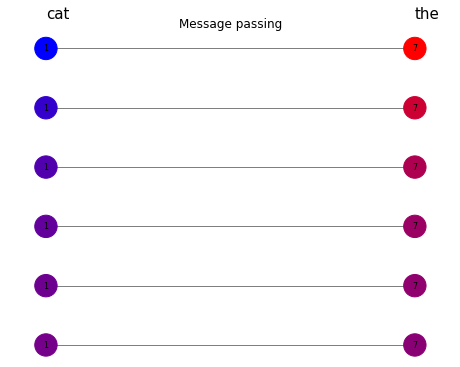

In [87]:
# Run, but do not modify the contents of this cell
sentence = "the cat"
word2idx = {"a":0, "cat":1, "did":2, "hat":3, "is":4, "on":5, "put":6, "the":7, "was":8,}
embedding = torch.tensor([
    [0.12345678, 0.98765432, 0.55555555],   # a       0
    [0.00000000, 0.00000000, 1.00000000],   # cat     1     BLUE
    [0.44444444, 0.66666666, 0.88888888],   # did     2
    [0.09876543, 0.12345678, 0.98765432],   # hat     3
    [0.55555555, 0.11111111, 0.22222222],   # is      4
    [0.33333333, 0.44444444, 0.66666666],   # on      5
    [0.88888888, 0.09876543, 0.12345678],   # put     6
    [1.00000000, 0.00000000, 0.00000000],   # the     7     RED
    [0.22222222, 0.33333333, 0.44444444],   # was     8
])
embedding_matrix = embedding.numpy()
util_show_message_passing(
    sentence=sentence,
    word2idx=word2idx,
    embedding_matrix=embedding_matrix,
    msg_weight=0.2,
    num_iter=5,
)

## 5.5 <font size=3> [2 pts] Message passing pt 2

Run the cell below to develop an intuitive sense for message passing. Modify only the ADJUSTABLE PARAMETERS:
* **Message weight.** choose any number between 0.0 and 1.0, and
* **Sentence.** Choose any sentence in all lower case letters, with no special characters or punctuation, containing only the words 'a', 'cat', 'did', 'hat', 'is', 'on', 'put', 'the', 'was'.

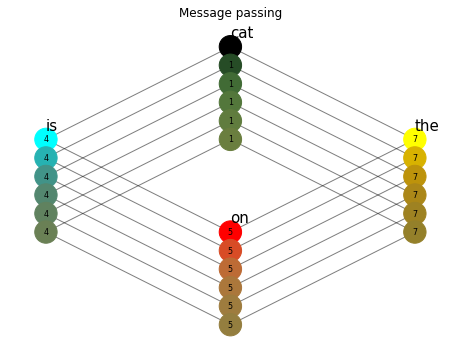

In [88]:
# Run this cell, modifying the contents only as indicated

# ADJUSTABLE PARAMETERS
SENTENCE = "the cat is on the"
MSG_WEIGHT = 0.15

# Do not modify any lines below here
word2idx = {"a":0, "cat":1, "did":2, "hat":3, "is":4, "on":5, "put":6, "the":7, "was":8,}
embedding = torch.tensor([
    [0.5, 0.5, 0.5],   # a       0
    [0.0, 0.0, 0.0],   # cat     1
    [0.0, 0.0, 1.0],   # did     2
    [0.0, 1.0, 0.0],   # hat     3
    [0.0, 1.0, 1.0],   # is      4
    [1.0, 0.0, 0.0],   # on      5
    [1.0, 0.0, 1.0],   # put     6
    [1.0, 1.0, 0.0],   # the     7
    [1.0, 1.0, 1.0],   # was     8
])
embedding_matrix = embedding.numpy()
util_show_message_passing(
    sentence=SENTENCE,
    word2idx=word2idx,
    embedding_matrix=embedding_matrix,
    msg_weight=MSG_WEIGHT,
    num_iter=5,
)

**Question:** Consider the sentence fragments (1) "the cat is on the" and (2) "the cat is the hat". In the first sentence fragment, the word "the" moves from bright yellow to a muddy orange. In the second fragment, the word "the" moves from bright yellow to relatively bright green. This is because...

In [89]:
def part_5_message_passing_q_response() -> str:
    """
    return
                  str        string that best answers the question
    """

    #return "...of the stochasticity involved in message passing."
    #return "...in the first fragment, all the neighboring nodes are orange, while in the second fragment, all the nodes are green"
    #return "...in the first fragment, there is a muddy brown neighbor node that heavily influences it"
    return "...in the second fragment, the -the- node has a cyan neighbor, which when combined with yellow gives green and the other neighbors only reinforce this greenness"
    #return "...in both fragments, the word the only has one neighbor"
    #return "...in the first fragment, the word -is- never influences the word -the-"
#     return "Yo"

## 5.6 <font size=3> [1 pts] Pooling node features to get a graph-level label

So far, we have discussed features of nodes, but our ultimate goal is to classify sentences. That is, for any given sentence, we want to assign a single integer to it (a 0 if the sentence is a command, a 1 if it is a question, and a 2 if it is a statement). So how do we turn the set of all those feature values that we see underneath the words in those sentence graphs into a single number? There are many ways to do it, but the way we'll pick is to just take their collective average. This is called *global average pooling*.

We'll get to using a full GAT soon, but let's build one final piece of intuition before we do.

In the body of the function below:
1. For each *unique* word in the sentence, find its set of feature values from the embedding matrix, add its values to a list, and take the total mean of all those values.
2. Return this mean.

In [90]:
def get_global_average_pooling(sentence, word2idx, embedding_matrix) -> float:
    """
    params
        sentence               str
        word2idx               dict[str,int]
        embedding_matrix       np.array
    return
        gap                    float
    """

    words = sentence.lower().rstrip(".!?").split()
    uniques = set(words)
    
    vs = [embedding_matrix[word2idx[w]] for w in uniques if w in word2idx]
    
    if not vs:
        return 0.0
    
    gap = np.mean(vs)
    
    return gap

**Unit test**

Running the cell below should show the following output.

> '0.4667'

In [91]:
# Run, but do not modify the contents of this cell
sentence = "the cat is on the"
word2idx = {"a":0, "cat":1, "did":2, "hat":3, "is":4, "on":5, "put":6, "the":7, "was":8,}
embedding = torch.tensor([
    [0.5, 0.5, 0.5],   # a       0
    [0.0, 0.0, 0.0],   # cat     1
    [0.0, 0.0, 1.0],   # did     2
    [0.0, 1.0, 0.0],   # hat     3
    [0.0, 1.0, 1.0],   # is      4
    [1.0, 0.0, 0.0],   # on      5
    [1.0, 0.0, 1.0],   # put     6
    [1.0, 1.0, 0.0],   # the     7
    [1.0, 1.0, 1.0],   # was     8
])
embedding_matrix = embedding.numpy()
gap = get_global_average_pooling(
    sentence=sentence,
    word2idx=word2idx, 
    embedding_matrix=embedding_matrix,
)
print(f"{gap:.4f}")

0.4167


## 5.7 <font size=3> [0 pts] Training a GAT network 

Thus far in this part of the assignment, we have developed the intuition behind the key components of a Graph Attention Network (GAT), which is a particular type of Graph Neural Network (GNN). The primary mechanism of every GNN is *message passing.* This was explored in the previous subparts. 

The core extension from general GNN to GAT is the addition of an *attention.* This is essentially the tracking of learnable edge weight parameters in a fully-connected graph. In this application, the fully connected graph where attention is tracked has token words as nodes and attention weights stored along the edges between those words. This tracks how much a given token word should weigh information passed to it from any other token word in a sentence graph.

Setting up a GAT network from scratch is currently beyond the scope of this course. Thus, we provide a pre-assembled GAT-based sentence classifier class that fits the particular application of this part of the assignment.

First, run the cell below to set up the embedding that will be used. It should display the following as output.

> `[0.5488 0.7152 0.6028]`

In [92]:
# Run, but do not modify the contents of this cell
tokenized, labels, word2idx = get_tokenized_sentences_and_labels()
np.random.seed(0)
embedding = torch.tensor(np.random.rand(9, 16)).float()
print(f"{np.round(embedding.numpy()[0,:3],4)}")

[0.5488 0.7152 0.6028]


Now run the utility function cells below.

In [93]:
# Utility function
def util_get_train_test_split(tokenized, labels, test_size=0.5, show=False):

    tokenized_train, tokenized_test, labels_train, labels_test = train_test_split(
        tokenized, 
        labels, 
        test_size=test_size, 
        random_state=0
        )

    if show:
        print("num of training sentences : ", len(tokenized_train))
        print("num of test sentences     : ", len(tokenized_test))
        print("tokenized_train[0]        : ", tokenized_train[0])
        print("tokenized_train[1]        : ", tokenized_train[1])

    return tokenized_train, tokenized_test, labels_train, labels_test

In [94]:
# Utility function
def util_get_trained_GAT(
    tokenized_train:list=[],
    labels_train:list=[],
    lr=0.01,
    epochs=100,
    show=False,
    ):
    
    model = nlp_data.GATSentenceClassifier()
    model.fit(
        tokenized=tokenized_train, 
        labels=labels_train, 
        word2idx=word2idx, 
        embedding=embedding, 
        lr=lr,
        epochs=epochs,
        show=show,
        )

    return model

**Unit test**

Running the cell below should show the output shown as a comment below it:

In [95]:
# Run, but do not modify the contents of this cell
tokenized_train, tokenized_test, labels_train, labels_test = util_get_train_test_split(
    tokenized, 
    labels, 
    test_size=0.5, 
    show=True,
)
model = util_get_trained_GAT(
    tokenized_train=tokenized_train, 
    labels_train=labels_train,
    lr=0.01,
    epochs=100,
    show=True,
)
labels_predicted = model.evaluate(
    tokenized=tokenized_test, 
    labels_true=labels_test, 
    show=True
)

num of training sentences :  20
num of test sentences     :  20
tokenized_train[0]        :  ['the', 'cat', 'put', 'a', 'hat', 'on']
tokenized_train[1]        :  ['is', 'the', 'hat', 'on', 'the', 'cat']

GATSentenceClassifier's architecture has been set
embedding_dim   :  16
heads           :  2
hidden_channels :  16
num_classes     :  3
Layer setup     : GATConv layer 1
Layer setup     : GATConv layer 2
Layer setup     : global mean pool
Layer setup     : linear (identity)
Optimizer setup : Adam : lr = 0.01

Beginning GATSentenceClassifier training...


C:\Users\yeyan\anaconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



Epoch 0, loss 23.6150
Epoch 10, loss 17.6130
Epoch 20, loss 0.3675
Epoch 30, loss 0.0685
Epoch 40, loss 0.0273
Epoch 50, loss 0.0164
Epoch 60, loss 0.0102
Epoch 70, loss 0.0069
Epoch 80, loss 0.0054
Epoch 90, loss 0.0038

GTASentenceClassifier accuracy report
num correctly predicted :  20
num total               :  20
accuracy                :   1.000
accuracy (percent)      :  100.0%


In [96]:
"""
num of training sentences :  20
num of test sentences     :  20
tokenized_train[0]        :  ['the', 'cat', 'put', 'a', 'hat', 'on']
tokenized_train[1]        :  ['is', 'the', 'hat', 'on', 'the', 'cat']

GATSentenceClassifier's architecture has been set
embedding_dim   :  16
heads           :  2
hidden_channels :  16
num_classes     :  3
Layer setup     : GATConv layer 1
Layer setup     : GATConv layer 2
Layer setup     : global mean pool
Layer setup     : linear (identity)
Optimizer setup : Adam : lr = 0.01

Beginning GATSentenceClassifier training...
Epoch  0, loss ???   (between 19.0-30.0)
Epoch 10, loss ???
Epoch 20, loss ???
Epoch 30, loss ???
Epoch 40, loss ???
Epoch 50, loss ???
Epoch 60, loss ???
Epoch 70, loss ???
Epoch 80, loss ???
Epoch 90, loss ???  (less than 0.01)

GTASentenceClassifier accuracy report
num correctly predicted :  20
num total               :  20
accuracy                :   1.000
accuracy (percent)      :  100.0%
"""

pass

## 5.8 <font size=3> [0 pts] Experiments

Run the cell below any number of times, changing only the hyperparameters, in order to answer the analysis questions below.

In [97]:
# Run this cell, modifying only the parameters indicated

# These hyperparameters may be modified
EPOCHS = 100
LR = 0.15
TEST_SIZE = 0.5

# Do not modify the lines below this comment
tokenized, labels, word2idx = get_tokenized_sentences_and_labels()
np.random.seed(0)
embedding = torch.tensor(np.random.rand(9, 16)).float()

tokenized_train, tokenized_test, labels_train, labels_test = util_get_train_test_split(
    tokenized, 
    labels, 
    test_size=TEST_SIZE, 
    show=True,
)
model = util_get_trained_GAT(
    tokenized_train=tokenized_train, 
    labels_train=labels_train,
    lr=LR,
    epochs=EPOCHS,
    show=True,
)
labels_predicted = model.evaluate(
    tokenized=tokenized_test, 
    labels_true=labels_test, 
    show=True,
)

num of training sentences :  20
num of test sentences     :  20
tokenized_train[0]        :  ['the', 'cat', 'put', 'a', 'hat', 'on']
tokenized_train[1]        :  ['is', 'the', 'hat', 'on', 'the', 'cat']

GATSentenceClassifier's architecture has been set
embedding_dim   :  16
heads           :  2
hidden_channels :  16
num_classes     :  3
Layer setup     : GATConv layer 1
Layer setup     : GATConv layer 2
Layer setup     : global mean pool
Layer setup     : linear (identity)
Optimizer setup : Adam : lr = 0.15

Beginning GATSentenceClassifier training...
Epoch 0, loss 175.4142
Epoch 10, loss 29.9136
Epoch 20, loss 36.4591
Epoch 30, loss 45.3052
Epoch 40, loss 50.5475
Epoch 50, loss 40.0001
Epoch 60, loss 30.6987
Epoch 70, loss 54.5277
Epoch 80, loss 29.3760
Epoch 90, loss 32.2518

GTASentenceClassifier accuracy report
num correctly predicted :  8
num total               :  20
accuracy                :   0.400
accuracy (percent)      :  40.0%


## 5.9 <font size=3> [2 pts] Analysis

**Question 1:** Concerning the *learning rate* hyperparameter, which of the following statements is most accurate?

In [98]:
def part_5_q1_response() -> str:
    """
    return
                  str        string that best answers the question
    """
    
    #return "The more the learning rate is increased, the better the resulting trained model will be in terms of accuracy"
    #return "The more the learning rate is increased, the worse the resulting trained model will be in terms of accuracy"
    #return "No matter the learning rate, the loss will always decrease from one epoch to the next"
    #return "No matter the learning rate, the loss will always increase from one epoch to the next"
    #return "The value of the ideal learning rate for the GAT as we have set it up is at least 0.25"
    return "The value of the ideal learning rate for the GAT as we have set it up is less than 0.25"
#     return "Yo"